# TBD - etap 2a

### Michał Kopyt, Rafał Kulus, Adrian Prorok

## Wczytanie danych


In [ ]:
pip install googledrivedownloader

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path

path_dir = str(Path.home()) + "/data/2020/"  # ustawmy sciezke na HOME/data/2020
archive_dir = path_dir + "survey.zip"        # plik zapiszemy pod nazwa survey.zip

# sciagniecie pliku we wskazane miejsce
gdd.download_file_from_google_drive(file_id='1dfGerWeWkcyQ9GX9x20rdSGj7WtEpzBB',
                                    dest_path=archive_dir,
                                    unzip=True)

Unzipping...Done.


##  Podłączenie do sesji Spark


In [6]:
from pyspark.sql import SparkSession

spark = SparkSession \
.builder \
.config("spark.executor.instances", "1")\
.config('spark.driver.memory','1g')\
.config('spark.executor.memory', '1g') \
.getOrCreate()

## Dostęp do danych

In [7]:
import os
user_name = 'jovyan'
# ścieżka dostępu do pliku
csv_path = 'file:////home/jovyan/data/2020/survey_results_public.csv'
df = spark.read.csv(csv_path, inferSchema=True, header="true", nullValue='NA', nanValue='NA',emptyValue='NA')

## <span style='background:yellow'> a) Ile jest unikalnych odpowiedzi w zapytaniu o poziom wykształcenia (EdLevel)? </span>

In [11]:
df_ed_level = df.select(df.EdLevel).distinct() # stworz nowy DF zawierajacy tylko unikalne wartosci poziomow wyksztalcenia

print(f'Liczba unikalnych odpowiedzi w zapytaniu o poziom wyksztalcenia: {df_ed_level.count()}')

Liczba unikalnych odpowiedzi w zapytaniu o poziom wyksztalcenia: 10


## <span style='background:yellow'> b) Podaj średnią liczbę godzin przepracowywanych przez respondentów pogrupowanych ze względu na kraj. </span>

In [44]:
df.groupBy("Country").avg("WorkWeekHrs").show() # dokonaj grupowania po Country i policz srednia liczbe przepracowywanych godzin w tygodniu przez respondentow

+--------------------+------------------+
|             Country|  avg(WorkWeekHrs)|
+--------------------+------------------+
|       Côte d'Ivoire|              32.0|
|            Paraguay|            29.875|
|The former Yugosl...|              39.5|
|               Yemen|              40.0|
|             Senegal|34.285714285714285|
|              Sweden|  40.7496062992126|
|  Hong Kong (S.A.R.)|42.298507462686565|
|   Republic of Korea|35.138888888888886|
|         Philippines| 37.32920792079208|
|             Eritrea|              null|
|            Djibouti|              45.0|
|           Singapore| 40.25684931506849|
|            Malaysia|39.255639097744364|
|              Turkey| 43.77202643171806|
|              Malawi|              36.5|
|                Iraq| 49.07142857142857|
|             Germany| 40.27298744460857|
|         Afghanistan|              46.5|
|            Cambodia|              44.0|
|              Jordan|45.806451612903224|
+--------------------+------------

## <span style='background:yellow'> c) Narysuj wykres słupkowy popularności wykorzystywanych baz danych przez profesjonalnych programistów. Skorzystaj z funkcji split i posexplode. </span>

In [26]:
df_databases = df.select("DatabaseWorkedWith").filter("DatabaseWorkedWith is not NULL")
df_databases.show()

+--------------------+
|  DatabaseWorkedWith|
+--------------------+
|Elasticsearch;Mic...|
|MySQL;PostgreSQL;...|
| MariaDB;MySQL;Redis|
|Microsoft SQL Server|
|Firebase;MongoDB;...|
|Firebase;Microsof...|
|        MySQL;Oracle|
|          PostgreSQL|
|Microsoft SQL Ser...|
|Elasticsearch;Mar...|
|MariaDB;Microsoft...|
|IBM DB2;MariaDB;M...|
|Firebase;MariaDB;...|
|   PostgreSQL;SQLite|
|              Oracle|
|          PostgreSQL|
|Elasticsearch;MyS...|
|Microsoft SQL Ser...|
|        MySQL;SQLite|
|MongoDB;MySQL;Pos...|
+--------------------+
only showing top 20 rows



In [42]:
from pyspark.sql.functions import split, col, posexplode

df_databases_splitted = df_databases.select(posexplode(split(col("DatabaseWorkedWith"), ";")).alias("Position", "Database"))
df_databases_splitted.show()

+--------+--------------------+
|Position|            Database|
+--------+--------------------+
|       0|       Elasticsearch|
|       1|Microsoft SQL Server|
|       2|              Oracle|
|       0|               MySQL|
|       1|          PostgreSQL|
|       2|               Redis|
|       3|              SQLite|
|       0|             MariaDB|
|       1|               MySQL|
|       2|               Redis|
|       0|Microsoft SQL Server|
|       0|            Firebase|
|       1|             MongoDB|
|       2|          PostgreSQL|
|       3|              SQLite|
|       0|            Firebase|
|       1|Microsoft SQL Server|
|       0|               MySQL|
|       1|              Oracle|
|       0|          PostgreSQL|
+--------+--------------------+
only showing top 20 rows



<AxesSubplot: xlabel='Database'>

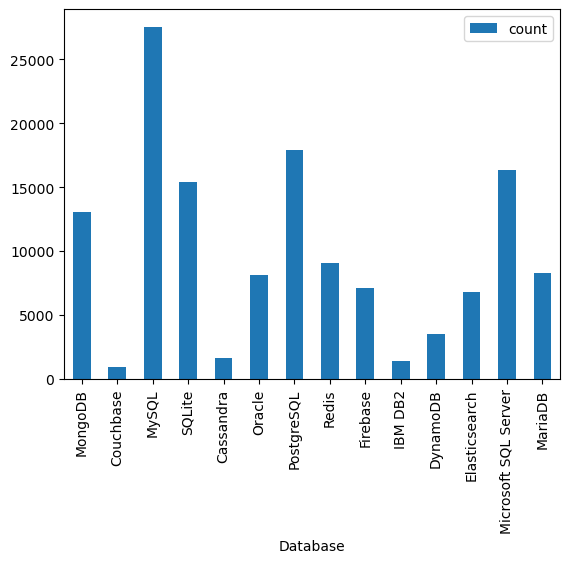

In [41]:
df_databases_splitted.groupBy("Database").count().toPandas().plot.bar(x="Database")

## <span style='background:yellow'> d1) Sprawdź czy można bardziej poprawić jakość predykcji dla zadania z tego notatnika: dodając cechy? </span>

## <span style='background:yellow'> d2) Sprawdź czy można bardziej poprawić jakość predykcji dla zadania z tego notatnika: zmieniając model? </span>

## <span style='background:yellow'> d3) Sprawdź czy można bardziej poprawić jakość predykcji dla zadania z tego notatnika: lepiej dobierając parametry nowego modelu? </span>

In [46]:
spark.stop()